## Importing the necessary libraries

In [1]:
import numpy as np 
import pandas as pd  
import torch
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import torch.nn.functional as F 

data_dir = './fire_dataset'

In [2]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
from torchvision import transforms as T,datasets  
from torchvision.models import squeezenet1_0

In [3]:
class CNFG:
    epochs =20                             
    lr = 0.001                             
    batch_size = 256              
    img_size = 224
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))

Device:cpu


## Transforming the data

In [4]:
data_transform = T.Compose([
                             T.Resize(size=(CNFG.img_size,CNFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [5]:
data = datasets.ImageFolder(data_dir,       
                    transform=data_transform)
total_count = len(data) 
total_count

2105

In [6]:
train_count = int(0.6 * total_count) 
valid_count = int(0.3 * total_count)
test_count = total_count - train_count - valid_count
train_data, val_data, test_data = torch.utils.data.random_split(data, (train_count, valid_count, test_count))  
print("Train data: {} images".format(len(train_data))) 
print("Validation data: {} images".format(len(val_data))) 
print("Test data: {} images".format(len(test_data)))

Train data: 1263 images
Validation data: 631 images
Test data: 211 images


### Method to show the accuracy of the model

In [7]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [8]:
train_data.dataset.classes

['Fire', 'Neutral']

In [9]:
train_data

In [12]:
trainloader = DataLoader(train_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(val_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader)))  
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:5
No. of Total examples:1263
No. of batches in validationloader:3
No. of Total examples:631
No. of batches in testloader:1
No. of Total examples:211


In [13]:
trainloader

In [15]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = squeezenet1_0(pretrained=True) #load pretrained model

C:\Users\Shiva\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shiva\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\Shiva/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth
100%|█████████████████████████████████████████████████████████████████████████████| 4.78M/4.78M [00:00<00:00, 19.4MB/s]


In [16]:
model.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

### Updating the pretrained model:

In [17]:
for param in model.parameters():
    param.requires_grad=False 

In [18]:
model.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))

In [19]:
model.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [21]:
from torchsummary import  summary
model.to(device)# move the model to CPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,

### Defining the method to train the model:

In [22]:
class ModelTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular 

    
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(outputs,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(outputs,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() 
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) 
            
            model.eval()  
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) 
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'fire_squeeze_net.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))


In [23]:
criterion = nn.CrossEntropyLoss()

### Training the model:

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CNFG.lr)

trainer = ModelTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = 25)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.7411694327990214
Epoch : 1 Train Loss : 0.938303 Train Acc : 0.402206
Epoch : 1 Valid Loss : 0.741169 Valid Acc : 0.514421


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.7411694327990214 --> 0.5084401369094849
Epoch : 2 Train Loss : 0.632897 Train Acc : 0.648898
Epoch : 2 Valid Loss : 0.508440 Valid Acc : 0.837207


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.5084401369094849 --> 0.36635152498881024
Epoch : 3 Train Loss : 0.432009 Train Acc : 0.836222
Epoch : 3 Valid Loss : 0.366352 Valid Acc : 0.892759


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.36635152498881024 --> 0.27371945977211
Epoch : 4 Train Loss : 0.319575 Train Acc : 0.893309
Epoch : 4 Valid Loss : 0.273719 Valid Acc : 0.914303


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.27371945977211 --> 0.22164489328861237
Epoch : 5 Train Loss : 0.237575 Train Acc : 0.912225
Epoch : 5 Valid Loss : 0.221645 Valid Acc : 0.927521


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.22164489328861237 --> 0.16474256416161856
Epoch : 6 Train Loss : 0.200492 Train Acc : 0.920205
Epoch : 6 Valid Loss : 0.164743 Valid Acc : 0.952337


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.16474256416161856 --> 0.13788280387719473
Epoch : 7 Train Loss : 0.158893 Train Acc : 0.939177
Epoch : 7 Valid Loss : 0.137883 Valid Acc : 0.946932


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.140859 Train Acc : 0.944368
Epoch : 8 Valid Loss : 0.146163 Valid Acc : 0.943934


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.13788280387719473 --> 0.13058924923340479
Epoch : 9 Train Loss : 0.128264 Train Acc : 0.951732
Epoch : 9 Valid Loss : 0.130589 Valid Acc : 0.947446


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.13058924923340479 --> 0.12173951665560405
Epoch : 10 Train Loss : 0.119317 Train Acc : 0.957146
Epoch : 10 Valid Loss : 0.121740 Valid Acc : 0.948037


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.12173951665560405 --> 0.11678288877010345
Epoch : 11 Train Loss : 0.099428 Train Acc : 0.962781
Epoch : 11 Valid Loss : 0.116783 Valid Acc : 0.951943


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.11678288877010345 --> 0.1052360658844312
Epoch : 12 Train Loss : 0.098954 Train Acc : 0.964455
Epoch : 12 Valid Loss : 0.105236 Valid Acc : 0.956047


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.088382 Train Acc : 0.969812
Epoch : 13 Valid Loss : 0.107675 Valid Acc : 0.954350


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.1052360658844312 --> 0.10378319770097733
Epoch : 14 Train Loss : 0.085495 Train Acc : 0.969923
Epoch : 14 Valid Loss : 0.103783 Valid Acc : 0.964450


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.10378319770097733 --> 0.09091239174207051
Epoch : 15 Train Loss : 0.077614 Train Acc : 0.976174
Epoch : 15 Valid Loss : 0.090912 Valid Acc : 0.962557


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.074327 Train Acc : 0.973941
Epoch : 16 Valid Loss : 0.091372 Valid Acc : 0.968159


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.080254 Train Acc : 0.970760
Epoch : 17 Valid Loss : 0.104083 Valid Acc : 0.962557


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.065434 Train Acc : 0.978351
Epoch : 18 Valid Loss : 0.091405 Valid Acc : 0.970763


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.070137 Train Acc : 0.974611
Epoch : 19 Valid Loss : 0.096682 Valid Acc : 0.967568


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.066160 Train Acc : 0.976007
Epoch : 20 Valid Loss : 0.102252 Valid Acc : 0.965358


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.09091239174207051 --> 0.08143803973992665
Epoch : 21 Train Loss : 0.061455 Train Acc : 0.981809
Epoch : 21 Valid Loss : 0.081438 Valid Acc : 0.969658


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.08143803973992665 --> 0.07805020486315091
Epoch : 22 Train Loss : 0.067832 Train Acc : 0.975392
Epoch : 22 Valid Loss : 0.078050 Valid Acc : 0.978970


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.07805020486315091 --> 0.07622074087460835
Epoch : 23 Train Loss : 0.064085 Train Acc : 0.978740
Epoch : 23 Valid Loss : 0.076221 Valid Acc : 0.973367


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid_loss decreased 0.07622074087460835 --> 0.07216840858260791
Epoch : 24 Train Loss : 0.057729 Train Acc : 0.980358
Epoch : 24 Valid Loss : 0.072168 Valid Acc : 0.978970


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.054153 Train Acc : 0.981753
Epoch : 25 Valid Loss : 0.076982 Valid Acc : 0.977274


## Loading the trained model and testing

In [25]:
model.load_state_dict(torch.load('fire_squeeze_net.pt'))
model.eval()
test_loss = 0.0
test_acc = 0.0
for images,labels in tqdm(testloader):
        
        # move the data to CPU
        images = images.to(device) 
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs,labels)
        
        test_loss += loss.item()
        test_acc += accuracy(outputs,labels)

print("Test Loss : {:.6f} Test Acc : {:.6f}".format(test_loss / len(testloader), test_acc / len(testloader)))

  0%|          | 0/1 [00:00<?, ?it/s]

Test Loss : 0.079958 Test Acc : 0.957346


## Make predictions

In [28]:
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F 
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
from torchvision import transforms as T,datasets  
from torchvision.models import squeezenet1_0
from torch import nn


data_transform = T.Compose([
                             T.Resize(size=(224,224)), # Resizing the image to be 224 by 224
                            #  T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

]) 

class_map = [ 
    'fire',
    'no_fire'
]

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def predict_image_class_name(image_path,model): 
    
    # show image 
    imshow(data_transform(Image.open(image_path)))

    image = Image.open(image_path)
    image = data_transform(image)
    image = image.unsqueeze(0)
    image = image.to(device) 
    output = model(image)
    output = F.softmax(output,dim = 1)
    print("soft" , output)
    top_p,top_class = output.topk(1,dim = 1) 
    print( top_p , top_class)
    # return "Predicted :", train_data.dataset.classes[top_class.item()]
    return "Predicted :", class_map[top_class.item()]

# device 
device = torch.device("cpu" if torch.cuda.is_available() else "cpu") 

# make realtime predictions 
model = squeezenet1_0(pretrained=True) #load pretrained model 
model.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model.load_state_dict(torch.load('fire_squeeze_net.pt')) # load the model
model.to(device) 

def predict_img(image): 

    INPUT_DIM = 224 
    preprocess = T.Compose([
            T.Resize(INPUT_DIM ),
            # T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

#     imshow(preprocess(Image.open(image)))

    im = Image.open(image)
    im_preprocessed = preprocess(im) 
    batch_img_tensor = torch.unsqueeze(im_preprocessed, 0)
    output = model(batch_img_tensor) 
    confidence = F.softmax(output, dim=1)[0] * 100 
    _, indices = torch.sort(output, descending=True) 
    return [(class_map[idx], confidence[idx].item()) for idx in indices[0][:1]]


In [30]:
%%time
tello = predict_img("./TestingImages/34.jpg")
print((tello[0])[0])

fire
CPU times: total: 281 ms
Wall time: 99.8 ms


In [31]:
%%time
tello = predict_img("./TestingImages/37.jpg")
print((tello[0]))

('no_fire', 96.63951873779297)
CPU times: total: 312 ms
Wall time: 74 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


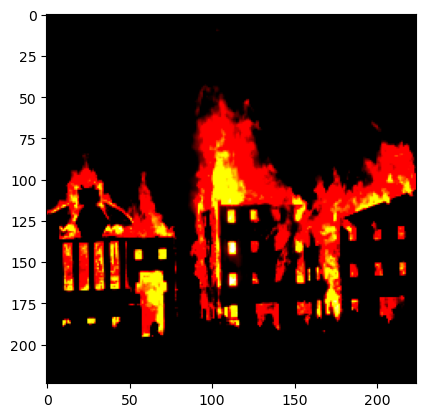

soft tensor([[9.9989e-01, 1.0864e-04]], grad_fn=<SoftmaxBackward0>)
tensor([[0.9999]], grad_fn=<TopkBackward0>) tensor([[0]])
CPU times: total: 1.02 s
Wall time: 404 ms


('Predicted :', 'fire')

In [32]:
%%time
predict_image_class_name('./TestingImages/34.jpg',model) 

In [33]:
predict_img('./TestingImages/35.jpg') 

[('fire', 99.60023498535156)]

## Deploying the model with OpenCV

### Importing the libraries

In [36]:
import numpy as np
import cv2
import torch
from time import time

### Testing the model with video

In [38]:
# importing libraries
import cv2
import numpy as np

font = cv2.FONT_HERSHEY_SIMPLEX
 
# Create a VideoCapture object and read from input file
cap = cv2.VideoCapture('testing_vid.mp4')
 
# Check if camera opened successfully
if (cap.isOpened()== False):
    print("Error opening video file")

currentframe = 0
# Read until video is completed
while(cap.isOpened()):
     
# Capture frame-by-frame
    ret, frame = cap.read()

    if ret == True:
    # Display the resulting frame
        name = 'TestingFrame\Frame(' + str(currentframe) + ').jpg'
        
        cv2.imwrite(name, frame)
        
        tello = predict_img(name)
        
        cv2.putText(frame, str((tello[0])[0]), (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
        cv2.imshow('Frame', frame)
        
         
    # Press Q on keyboard to exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
# Break the loop
    else:
        break
 
# When everything done, release
# the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()